In [1]:
import pandas as pd
from utils.dataloader import DataLoader
from settings.constants import TRAIN_CSV

train = pd.read_csv(TRAIN_CSV, header = 0)

X_raw = train.drop("stroke", axis=1)

loader = DataLoader()
loader.fit(X_raw)
X = loader.load_data()
y = train["stroke"]

In [2]:
X.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status
0,13,1,0,1,3,0.713046,0.888092,2
1,13,0,1,1,3,0.040347,0.275466,3
2,9,1,0,1,2,0.746745,0.302726,3
3,4,0,0,0,2,0.247576,0.197991,0
4,8,0,0,1,2,0.138999,0.216643,0


In [3]:
X.value_counts()

age  hypertension  heart_disease  ever_married  work_type  avg_glucose_level  bmi       smoking_status
0    0             0              0             3          0.041270           0.126100  0                 1
10   0             0              0             2          0.034531           0.346041  2                 1
9    1             0              1             3          0.108762           0.281525  2                 1
                                                           0.127828           0.498534  2                 1
                                                           0.197904           0.322581  3                 1
                                                                                                         ..
4    1             0              1             0          0.170760           0.904692  2                 1
                                                2          0.436525           0.510264  2                 1
5    0             0             

In [3]:
from collections import Counter

counter = Counter(y)
pos_weight = counter[0]/counter[1]
counter

Counter({0: 3889, 1: 199})

# Traditional ML models

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.metrics import roc_auc_score, fbeta_score, recall_score, average_precision_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import optuna as opt

## Base estimator performance

In [10]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

base_clf = RandomForestClassifier(class_weight='balanced', 
                                  n_jobs=-1)

scores = cross_validate(base_clf, X, y, scoring='average_precision', cv=sss, verbose=1, n_jobs=-1)
fig = px.box(scores, y='test_score')
fig.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


## XGBoost

In [11]:
dmatrix = xgb.DMatrix(data=X, label=y)
xgb_params = {
    'eval_metric':'aucpr',
    'objective': 'binary:logistic', 
    'scale_pos_weight': pos_weight/100
    }

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

cv_res = xgb.cv(dtrain=dmatrix,
                params=xgb_params,
                num_boost_round=1000,
                folds=sss,
                early_stopping_rounds=50,
                metrics='aucpr')

print(f'Validation precision-recall AUC {round(cv_res.loc[len(cv_res) - 1, "test-aucpr-mean"], 3)}')

In [31]:
cv_res

,train-aucpr-mean,train-aucpr-std,test-aucpr-mean,test-aucpr-std
0,0.048584,0.000000,0.048900,0.000000
1,0.096060,0.074255,0.067361,0.029035
2,0.165443,0.044576,0.131288,0.021847
3,0.204629,0.042659,0.163699,0.045364
4,0.248437,0.046257,0.187921,0.048214
5,0.291187,0.043155,0.187693,0.043316
6,0.330229,0.039177,0.201494,0.047785
7,0.360072,0.033901,0.210732,0.043398
8,0.376122,0.031856,0.214001,0.043703
9,0.393402,0.030021,0.216299,0.043727


c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


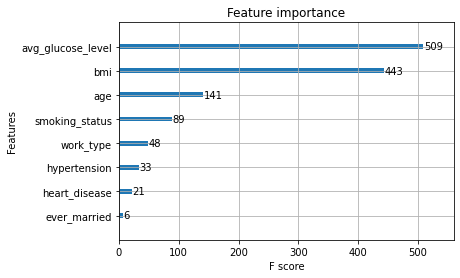

In [12]:
clf = xgb.XGBClassifier(**xgb_params)
clf.fit(X, y)
xgb.plot_importance(clf)
plt.show()

Optuna optimizations

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()
XGB_DB_URL = os.getenv('XGB_DB_URL')

In [75]:
def objective(trial,data=X,target=y):
    
    clf_params ={
        'eval_metric':'aucpr',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'max_depth': 3,
        'min_child_weight': 6,
        'alpha': trial.suggest_uniform('alpha', 5e-3, 1e-2),
    }
    
    if clf_params["booster"] == "gbtree" or clf_params["booster"] == "dart":
        clf_params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0.93, 0.96)
        clf_params['subsample'] = trial.suggest_uniform('subsample', 0.943, 0.946)
        clf_params['scale_pos_weight'] = trial.suggest_uniform('scale_pos_weight', 1.53, 1.55)
        clf_params['gamma'] =  trial.suggest_uniform("gamma", 8e-3, 3e-2)  
        clf_params["eta"] = trial.suggest_uniform("eta", 0.205, 0.215)
    '''
        
    if clf_params["booster"] == "dart":
        clf_params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        clf_params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        clf_params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        clf_params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)    
        
    '''
    
    dmatrix = xgb.DMatrix(data=data, label=target)
    
    pruning_callback = opt.integration.XGBoostPruningCallback(trial, 'test-aucpr')
    xgb_cv_res = xgb.cv(params=clf_params, dtrain=dmatrix, num_boost_round=500,
                        folds=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                        early_stopping_rounds=50, metrics='aucpr',
                        callbacks=[pruning_callback]
                        )
    
    aucpr = xgb_cv_res.loc[len(xgb_cv_res) - 1, "test-aucpr-mean"]
    
    return aucpr

xgb_study = opt.create_study(
    pruner=opt.pruners.MedianPruner(n_warmup_steps=10),
    direction='maximize',
    study_name='xgboost-reduced',
    storage=XGB_DB_URL
    )

xgb_study.optimize(objective, n_trials=400, n_jobs=-1)

[I 2021-10-21 22:25:24,258] A new study created in RDB with name: xgboost-reduced
c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

[I 2021-10-21 22:25:42,981] Trial 5 finished with value: 0.2464995 and parameters: {'alpha': 0.009591110997023316, 'colsample_bytree': 0.942612085816292, 'subsample': 0.9451880620199111, 'scale_pos_weight': 1.549243022311114, 'gamma': 0.021805722416554138, 'eta': 0.21341819631571582}. Best is trial 5 with value: 0.2464995.
[I 2021-10-21 22:25:43,370] Trial 1 finished with value: 0.24818389999999999 and parameters: {'alpha': 0.005285618654081135, 'colsample_bytree': 0.9579596008501592, 'subsample': 0.9455053223232528, 'scale_pos_weight': 1.539676638478191, 'gamma': 0.025510642575480906, 'eta': 0.2076328239227961}. Best is tria

In [76]:
try:
    xgb_study
except NameError:
    xgb_study = opt.load_study(study_name='xgboost-reduced', storage=XGB_DB_URL)
best = xgb_study.best_trial
print(f'Value {best.value}')
print(best.params)

Value 0.2572239
{'alpha': 0.0062545614364426, 'colsample_bytree': 0.9395599414116251, 'eta': 0.21111474540305314, 'gamma': 0.008068642975245555, 'scale_pos_weight': 1.5413490995959842, 'subsample': 0.9441851457784306}


### Visualisations

In [77]:
opt.visualization.plot_optimization_history(xgb_study)

In [78]:
opt.visualization.plot_edf(xgb_study)

In [79]:
opt.visualization.plot_param_importances(xgb_study)

In [80]:
opt.visualization.plot_parallel_coordinate(xgb_study)

## LGBM

In [56]:
dset = lgb.Dataset(data=X, label=y, 
                   #categorical_feature=['age','hypertension','heart_disease','ever_married','work_type','smoking_status']
                   )
lgb_params = {
    'metric':'average_precision',
    'objective':'binary', 
    'is_unbalance': True,
    'force_col_wise':True,
    'boosting_type': 'goss'
}


lgb_cv_res = lgb.cv(params=lgb_params,
                    train_set=dset,
                    num_boost_round=50,
                    folds=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0),
                    metrics='average_precision',
                    callbacks=[lgb.early_stopping(30)]
                    )

lgb_cv_res_df = pd.DataFrame(lgb_cv_res)

print(f'Best validation precision-recall AUC {round(lgb_cv_res_df["average_precision-mean"].max(), 2)} at iteration {lgb_cv_res_df["average_precision-mean"].idxmax()}')
print(f'Last validation precision-recall AUC {round(lgb_cv_res_df.loc[len(lgb_cv_res_df) - 1,"average_precision-mean"], 2)} at iteration {len(lgb_cv_res_df) - 1}')

[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 2861, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Number of positive: 139, number of negative: 2722
[LightGBM] [Info] Total Bins 540
[LightGBM] [Inf

Model performance without specifying categories seems to be better, but there are related HP to tune using Optuna  
However the difference among optimizers is not significant

In [57]:
lgb_cv_res_df

,average_precision-mean,average_precision-stdv
0,0.145334,0.024636
1,0.167569,0.027445
2,0.174953,0.028324
3,0.179029,0.027405
4,0.182255,0.027885
5,0.187835,0.026680
6,0.191697,0.025448
7,0.193907,0.027768
8,0.193765,0.028647
9,0.195590,0.028482


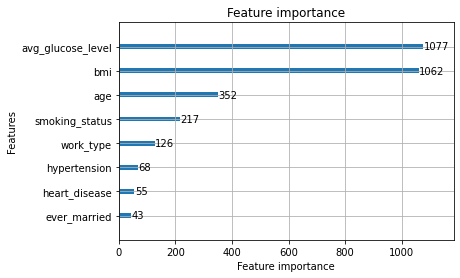

In [132]:
clf = lgb.LGBMClassifier(**lgb_params)
clf.fit(X, y)
lgb.plot_importance(clf)
plt.show()

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()
LGB_DB_URL = os.getenv('LGB_DB_URL')

In [61]:
def objective(trial,data=X,target=y, boosting_type='gbdt'):
    
    clf_params ={
        'metric':'average_precision',
        'is_unbalance': True,
        'objective': 'binary',
        'verbose': -1,
        'min_child_weight': 17,
        'max_bin': 58,
        'boosting_type': trial.suggest_categorical('booster', [boosting_type]), # trial.suggest_categorical('booster', ['gbdt', 'dart', 'goss']),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.4, 0.8),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0.07, 0.11),
    
        
        'cat_l2': trial.suggest_uniform('cat_l2', 2e-3, 0.0035),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 5, 15),
        'max_cat_threshold': trial.suggest_int('max_cat_threshold',12,25),
        'cat_smooth': trial.suggest_uniform('cat_smooth', 2.0, 6.5)
    }
    
    
    if clf_params["boosting_type"] in ['gbdt', 'rf', 'dart', 'goss']:
        #clf_params['max_bin'] = trial.suggest_int('max_bin', 55, 65)
        clf_params['num_leaves'] = trial.suggest_int('num_leaves', 38, 60)
        clf_params["max_depth"] = trial.suggest_int("max_depth", 5, 8)
        clf_params["eta"] = trial.suggest_uniform("eta", 0.07, 0.08)
        clf_params["min_split_gain"] = trial.suggest_uniform("min_split_gain", 0.013, 0.015)
        #clf_params['min_child_weight'] = trial.suggest_int('min_child_weight', 15, 19)
        clf_params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 1, 8)        
        clf_params['feature_fraction'] = trial.suggest_uniform('feature_fraction', 0.9435, 0.945)
        
    if clf_params['boosting_type'] in ['gbdt', 'rf', 'dart']:
        clf_params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 16)
        clf_params['bagging_fraction'] = 0.9
        clf_params['pos_bagging_fraction'] = trial.suggest_uniform('pos_bagging_fraction', 0.8, 1.0)
        clf_params['neg_bagging_fraction'] = trial.suggest_uniform('neg_bagging_fraction', 0.5, 0.7)      
                
    if clf_params["boosting_type"] == "dart":
        clf_params["uniform_drop"] = False
        clf_params["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-2, 1e-1)
        clf_params["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-1, 1.0)    
        clf_params["max_drop"] = trial.suggest_int("max_drop", 30, 60)  
        
        
    if clf_params['boosting_type'] == 'goss':
        clf_params['top_rate'] = round(trial.suggest_uniform('top_rate', 0.3, 0.5), 5)
        clf_params['other_rate'] =  round(trial.suggest_uniform('other_rate', 0, 1 - clf_params['top_rate']), 5)
        
    
    
    dmatrix = lgb.Dataset(data=data, label=target, categorical_feature=['age','hypertension','heart_disease','ever_married','work_type','smoking_status'])
    
    pruning_callback = opt.integration.LightGBMPruningCallback(trial, 'average_precision')
    
    #try:
    lgb_cv_res = lgb.cv(params=clf_params, train_set=dmatrix, num_boost_round=50 if clf_params['boosting_type'] == 'dart' else 100,
                        folds=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                        metrics='average_precision',
                        callbacks=[pruning_callback, lgb.log_evaluation(period=0)] if clf_params['boosting_type'] == 'dart' else
                        [lgb.log_evaluation(period=0), pruning_callback, lgb.early_stopping(30, verbose=False)])
    
    #except lgb.basic.LightGBMError:
    #    print('-!'*50+f'\n{clf_params["boosting_type"]} params are: top rate={clf_params.get("top_rate")}, other rate={clf_params.get("other_rate")}\n'+'-!'*50)
        
    df = pd.DataFrame(lgb_cv_res)
    
    aucpr = df["average_precision-mean"].max()
    trial.set_user_attr('n_estimators', df["average_precision-mean"].idxmax() + 1)
    
    return aucpr

def create_study(name):
    return opt.create_study(
        pruner=opt.pruners.MedianPruner(n_warmup_steps=10),
        direction='maximize',
        study_name=name,
        storage=LGB_DB_URL)
    
boosters = ['goss']
postfix = '-cat'
    
lgb_study = {booster: create_study(name=booster+postfix) for booster in boosters}


[I 2021-10-23 18:11:55,890] A new study created in RDB with name: goss-cat


In [62]:
for booster, study in lgb_study.items():
    study.optimize(lambda t: objective(t, boosting_type=booster), n_trials=500, n_jobs=-1)

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\optuna\study\study.py:393: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\lightgbm\basic.py:2065: UserWarning:

Using categorical_feature in Dataset.

c:\Users\Michel\Documents\NURE\

In [63]:
try:
    lgb_study
except NameError:
    lgb_study = {booster+postfix: opt.load_study(study_name=booster+postfix, storage=LGB_DB_URL) for booster in boosters}
    
for study in lgb_study.values():
    best = study.best_trial
    print(f'Value {best.value}')
    print(best.params)
    print(best.user_attrs)

Value 0.26532196167545063
{'booster': 'goss', 'cat_l2': 0.002832945022550406, 'cat_smooth': 5.4111463094755266, 'eta': 0.07328979517371839, 'feature_fraction': 0.9446167822698687, 'lambda_l1': 0.08016922106726923, 'lambda_l2': 0.6855920985773585, 'max_bin': 58, 'max_cat_threshold': 13, 'max_depth': 8, 'min_child_weight': 17, 'min_data_in_leaf': 7, 'min_data_per_group': 13, 'min_split_gain': 0.013653991391068496, 'num_leaves': 50, 'other_rate': 0.12836337511071985, 'top_rate': 0.38895880168990904}
{'n_estimators': 23}


In [64]:
opt.visualization.plot_optimization_history(lgb_study.get(boosters[0]))

In [65]:
opt.visualization.plot_edf(list(lgb_study.values()))

In [11]:
opt.visualization.plot_edf(list(lgb_study.values()))

In [12]:
opt.visualization.plot_param_importances(lgb_study.get(boosters[0]))

In [17]:
opt.visualization.plot_parallel_coordinate(lgb_study.get(boosters[0]))

In [18]:
opt.visualization.plot_param_importances(lgb_study.get(boosters[1]))

In [19]:
opt.visualization.plot_parallel_coordinate(lgb_study.get(boosters[1]))

In [66]:
opt.visualization.plot_param_importances(lgb_study.get(boosters[0]))

In [67]:
opt.visualization.plot_parallel_coordinate(lgb_study.get(boosters[0]))

In [71]:
opt.visualization.plot_slice(lgb_study.get(boosters[0]), params=['lambda_l1'])

## Catboost

## FLAML experiments

In [63]:
sample_weight = np.ones(len(y))
sample_weight[y == 1] *= counter[0]/counter[1]

from flaml.model import XGBoostSklearnEstimator, LGBMEstimator

class CostSensitiveXGB(XGBoostSklearnEstimator):
    def __init__(self, **params):
        super().__init__(booster='dart', scale_pos_weight=counter[0]/(counter[1]), **params)
        
class CostSensitiveLGBM(LGBMEstimator):
    def __init__(self, **params):
        super().__init__(boosting_type='dart', scale_pos_weight=counter[0]/(counter[1]), **params)

from flaml import AutoML
automl = AutoML()
automl.add_learner(learner_name='CostXGB', learner_class=CostSensitiveXGB)
automl.add_learner(learner_name='CostLGBM', learner_class=CostSensitiveLGBM)

automl_params = {
    "time_budget": 60*30,
    "metric": 'ap',
    "eval_method":'cv',
    "estimator_list": ['xgboost'],
    "task": 'classification',
    "log_file_name": 'stroke_classification.log',
    "seed": 7,
    "n_jobs": 8,
    "split_ratio": 0.3,
    "n_splits": 10,
    "split_type": 'stratified',
    "sample_weight": sample_weight
}

In [64]:
automl.fit(X_train=X, y_train=y, **automl_params)

[flaml.automl: 10-20 17:47:03] {1459} INFO - Data split method: stratified
[flaml.automl: 10-20 17:47:03] {1463} INFO - Evaluation method: cv
[flaml.automl: 10-20 17:47:03] {1511} INFO - Minimizing error metric: 1-ap
[flaml.automl: 10-20 17:47:03] {1548} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 10-20 17:47:03] {1778} INFO - iteration 0, current learner xgboost
[flaml.automl: 10-20 17:47:04] {1895} INFO - Estimated sufficient time budget=3320s. Estimated necessary time budget=3s.
[flaml.automl: 10-20 17:47:04] {1967} INFO -  at 0.4s,	estimator xgboost's best error=0.2208,	best estimator xgboost's best error=0.2208
[flaml.automl: 10-20 17:47:04] {1778} INFO - iteration 1, current learner xgboost
[flaml.automl: 10-20 17:47:04] {1967} INFO -  at 0.8s,	estimator xgboost's best error=0.1936,	best estimator xgboost's best error=0.1936
[flaml.automl: 10-20 17:47:04] {1778} INFO - iteration 2, current learner xgboost
[flaml.automl: 10-20 17:47:05] {1967} INFO -  at 1

KeyboardInterrupt: 

In [48]:
print('Best hyperparmeter config:', automl.best_config)
print('Best ROC_PR on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 144, 'max_leaves': 24, 'min_child_weight': 0.09194426120273991, 'learning_rate': 0.07146410645081408, 'subsample': 0.9692308733367908, 'colsample_bylevel': 0.9305472752621012, 'colsample_bytree': 0.8849860673444865, 'reg_alpha': 0.003396501679614063, 'reg_lambda': 82.49928920076438}
Best ROC_PR on validation data: 0.8212
Training duration of best run: 12.33 s


In [49]:
automl.model.estimator

XGBClassifier(base_score=0.5, booster='dart',
              colsample_bylevel=0.9305472752621012, colsample_bynode=1,
              colsample_bytree=0.8849860673444865, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.07146410645081408,
              max_delta_step=0, max_depth=0, max_leaves=24,
              min_child_weight=0.09194426120273991, missing=nan,
              monotone_constraints='()', n_estimators=144, n_jobs=8,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.003396501679614063, reg_lambda=82.49928920076438,
              scale_pos_weight=19.542713567839197, subsample=0.9692308733367908,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [58]:
xgb_params = dict(
    bbase_score=0.5, booster='gbtree',
              colsample_bylevel=0.7821065428999804, colsample_bynode=1,
              colsample_bytree=0.86585064209194, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.05676981288924362,
              max_delta_step=0, max_depth=0, max_leaves=78,
              min_child_weight=35.020683109493056,
              monotone_constraints='()', n_estimators=12, n_jobs=8,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.0011944454888602083, reg_lambda=0.480781096367355,
              scale_pos_weight=counter[0]/counter[1], subsample=0.971784995750149,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0
)

lgbm_params = dict(
    objective='binary',
    boosting_type='dart',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_data_in_leaf=23,
    max_delta_step =23,
    min_gain_to_split=2,
    min_child_weight=0.5,
    scale_pos_weight=counter[0]/(counter[1]),
    metric='average_precision'
)

trad_classifiers = [
    SVC(class_weight='balanced', C=.005),
    RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=5, min_samples_split=4, min_samples_leaf=6, max_features='sqrt', n_estimators=50, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=50, learning_rate=0.001, max_depth=5, min_samples_split=4, min_samples_leaf=6, loss='exponential', max_features='log2'),
    LogisticRegression(class_weight='balanced', solver='liblinear', C=.1, n_jobs=-1),
    #XGBClassifier(**xgb_params),
    LGBMClassifier(**lgbm_params, n_jobs=-1)
]

In [59]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(
    C=[0.0001, 0.001, 0.01, 0.1, 1],
    solver=['liblinear','lbfgs','newton-cg']
)
rand_search = RandomizedSearchCV(estimator=trad_classifiers[-3], 
                                 param_distributions=param_grid, 
                                 scoring='average_precision', 
                                 n_iter=150, 
                                 n_jobs=-1, 
                                 cv=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                                 verbose=1)

search_result = rand_search.fit(X,y)
print(f'Best model {search_result.best_params_} with PR_AUC of {search_result.best_score_}')
means = search_result.cv_results_['mean_test_score']
stds = search_result.cv_results_['std_test_score']
params = search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

c:\Users\Michel\Documents\NURE\Python\DS Fundamentals\Final Project\app\env\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 15 is smaller than n_iter=150. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 15 candidates, totalling 150 fits


KeyboardInterrupt: 

In [60]:
log_cols = ["Classifier", "PR_AUC", "Recall (TPR)", "Fbeta"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
scoring = {
    'PR_AUC': 'average_precision',
    'recall': 'recall',
    'Fbeta': make_scorer(fbeta_score, beta=2)
}
acc_dict = {}

for clf in trad_classifiers:
    name = clf.__class__.__name__
    scores = cross_validate(clf, X, y, scoring=scoring, cv=sss, verbose=1, n_jobs=-1)
    roc_auc = scores['test_PR_AUC'].mean()
    recall = scores['test_recall'].mean()
    fbeta = scores['test_Fbeta'].mean()
    
    acc_dict[name] = np.array([roc_auc, recall, fbeta])

for clf in acc_dict:
    log_entry = pd.DataFrame([[clf, acc_dict[clf][0], acc_dict[clf][1], acc_dict[clf][2]]], columns = log_cols)
    log = log.append(log_entry)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

,Classifier,PR_AUC,Recall (TPR),Fbeta
0,SVC,0.189784,0.878333,0.366297
0,RandomForestClassifier,0.212700,0.755000,0.385929
0,GradientBoostingClassifier,0.235451,0.000000,0.000000
0,LogisticRegression,0.189418,0.828333,0.387422
0,LGBMClassifier,0.235003,0.753333,0.395536


<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='model performance', ylabel='Classifier'>

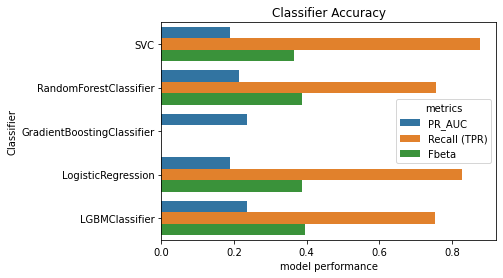

In [61]:
display(log)

plt.title('Classifier Accuracy')
log = pd.melt(log, id_vars='Classifier', var_name='metrics', value_name='model performance')
sns.set_color_codes("muted")
sns.barplot(x = 'model performance', y = 'Classifier', data = log, hue='metrics')

# Deep learning model

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

In [26]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

class_weights = {0: X.shape[0]/(counter[0]), 1: X.shape[0]/counter[1]}

def create_model(learn_rate=0.0001, epsilon=1e-7, drop_rate=0.3, weight_constraint=2, nodes=140, init_mode='lecun_uniform', act_func='sigmoid'):
    model = Sequential()
    model.add(Dense(units=nodes, input_dim=X.shape[1], activation=act_func, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint))),
    model.add(Dropout(drop_rate))
    model.add(Dense(units=1, activation='sigmoid'))
    model._name = '60-1'
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learn_rate, epsilon=epsilon), metrics=[AUC(curve='PR')], weighted_metrics=[AUC(curve='PR')])
    return model

dl_clf = KerasClassifier(build_fn=create_model, verbose=0, batch_size=10, class_weight=class_weights)

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(
    batch_size = [10, 20, 40, 60],
    epochs = [50, 100, 200],
    learn_rate = [0.0001, 0.001, 0.01],
    epsilon=[1e-7, 1e-5, 1e-3, 1e-1, 1],
    init_mode = ['lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    act_func = ['elu','relu'],
    weight_constraint = [1, 2, 3, 4, 5],
    drop_rate = np.arange(0.0,0.6,0.1),
    nodes = np.arange(60,260,20)
)
rand_search = RandomizedSearchCV(estimator=dl_clf, 
                                 param_distributions=param_grid, 
                                 scoring='average_precision', 
                                 n_iter=200, 
                                 n_jobs=-1, 
                                 cv=StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0), 
                                 verbose=1)
search_result = rand_search.fit(X,y)
print(f'Best model {search_result.best_params_} with PR_AUC of {search_result.best_score_}')
means = search_result.cv_results_['mean_test_score']
stds = search_result.cv_results_['std_test_score']
params = search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Best model {'weight_constraint': 1, 'nodes': 80, 'learn_rate': 0.0001, 'init_mode': 'glorot_uniform', 'epsilon': 0.001, 'epochs': 200, 'drop_rate': 0.4, 'batch_size': 20, 'act_func': 'relu'} with PR_AUC of 0.19970912317141393
0.1905770265717395 (0.028339059560505562) with: {'weight_constraint': 4, 'nodes': 80, 'learn_rate': 0.01, 'init_mode': 'he_normal', 'epsilon': 0.001, 'epochs': 100, 'drop_rate': 0.8, 'batch_size': 40, 'act_func': 'relu'}
0.16090430078568255 (0.028203087753878874) with: {'weight_constraint': 3, 'nodes': 160, 'learn_rate': 0.1, 'init_mode': 'lecun_uniform', 'epsilon': 1, 'epochs': 200, 'drop_rate': 0.0, 'batch_size': 10, 'act_func': 'elu'}
0.14007978270357058 (0.010898622419491773) with: {'weight_constraint': 1, 'nodes': 240, 'learn_rate': 0.0001, 'init_mode': 'he_uniform', 'epsilon': 1, 'epochs': 100, 'drop_rate': 0.4, 'batch_size': 40, 'act_func': 'relu'}
0.07840377953325674 (0.006666703563114997) 

In [86]:
dl_classifiers = [
    
    dl_clf
]

dl_classifiers[0].get_params()

{'verbose': 0,
 'batch_size': 10,
 'class_weight': {0: 1.0511699665723837, 1: 20.542713567839197},
 'build_fn': <function __main__.create_model(learn_rate=0.0001, epsilon=1e-07, drop_rate=0.3, weight_constraint=2, nodes=140, init_mode='lecun_uniform', act_func='sigmoid')>}

In [87]:
log_cols = ["Classifier", "PR_AUC", "Recall (TPR)", "Fbeta"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
scoring = {
    'PR_AUC': 'average_precision',
    'recall': 'recall',
    'Fbeta': make_scorer(fbeta_score, beta=2)
}
acc_dict = {}

for clf in dl_classifiers:
    name = clf.__class__.__name__
    scores = cross_validate(clf, X, y, scoring=scoring, cv=sss, verbose=1, n_jobs=-1)
    roc_auc = scores['test_PR_AUC'].mean()
    recall = scores['test_recall'].mean()
    fbeta = scores['test_Fbeta'].mean()
    
    acc_dict[name] = np.array([roc_auc, recall, fbeta])

for clf in acc_dict:
    log_entry = pd.DataFrame([[clf, acc_dict[clf][0], acc_dict[clf][1], acc_dict[clf][2]]], columns = log_cols)
    log = log.append(log_entry)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   34.5s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.8s finished


,Classifier,PR_AUC,Recall (TPR),Fbeta
0,KerasClassifier,0.108358,0.231667,0.095489


<AxesSubplot:title={'center':'Classifier Accuracy'}, xlabel='model performance', ylabel='Classifier'>

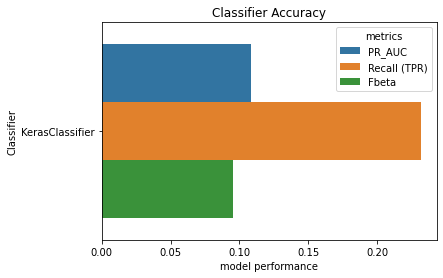

In [88]:
display(log)

plt.title('Classifier Accuracy')
log = pd.melt(log, id_vars='Classifier', var_name='metrics', value_name='model performance')
sns.set_color_codes("muted")
sns.barplot(x = 'model performance', y = 'Classifier', data = log, hue='metrics')

# Model export and validation

In [13]:
import pickle
import json
import pandas as pd
from sklearn.svm import SVC

from utils.dataloader import DataLoader 
from settings.constants import TRAIN_CSV


with open('settings/specifications.json') as f:
    specifications = json.load(f)

raw_train = pd.read_csv(TRAIN_CSV)
x_columns = specifications['description']['X']
y_column = specifications['description']['y']

X_raw = raw_train[x_columns]

loader = DataLoader()
loader.fit(X_raw)
X = loader.load_data()
y = raw_train.stroke

model = trad_classifiers[0]
model.fit(X, y)
with open(f'models/{model.__class__.__name__}.pickle', 'wb')as f:
    pickle.dump(model, f)

In [14]:
import pickle
import json
import pandas as pd
from sklearn.svm import SVC

from utils.dataloader import DataLoader 
from settings.constants import VAL_CSV


with open('settings/specifications.json') as f:
    specifications = json.load(f)

x_columns = specifications['description']['X']
y_column = specifications['description']['y']

raw_val = pd.read_csv(VAL_CSV)
x_raw = raw_val[x_columns]

loader = DataLoader()
loader.fit(x_raw)
X = loader.load_data()
y = raw_val.stroke

loaded_model = pickle.load(open('models/SVC.pickle', 'rb'))
loaded_model.score(X, y)

0.6438356164383562

Normalized CM
[[0.63374486 0.36625514]
 [0.16       0.84      ]]


C:\Users\Michel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, "SVC(C=0.005, class_weight='balanced')")

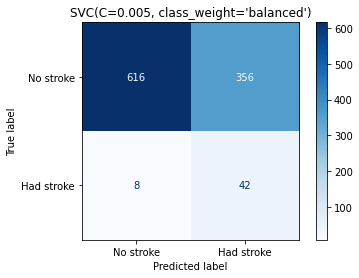

In [15]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

print(f'Normalized CM')
print(confusion_matrix(y,
                       loaded_model.predict(X),
                       normalize='true'))
disp = plot_confusion_matrix(loaded_model, X, y,
                             display_labels=['No stroke', 'Had stroke'],
                             cmap=plt.cm.Blues)
disp.ax_.set_title(f'{loaded_model}')

In [17]:
from sklearn.metrics import classification_report

target_names = ['No stroke', 'Stroke']
print(classification_report(y, loaded_model.predict(X), target_names=target_names))

              precision    recall  f1-score   support

   No stroke       0.99      0.63      0.77       972
      Stroke       0.11      0.84      0.19        50

    accuracy                           0.64      1022
   macro avg       0.55      0.74      0.48      1022
weighted avg       0.94      0.64      0.74      1022

